# A/B tests (3 / 3 part)

In [1]:
from config import connection
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from ab_functions import run_ab_test_ctr

import numpy as np
import pandas as pd
import pandahouse as ph
import seaborn as sns
sns.set(rc={'figure.figsize':(6, 18)})

## 3.1 Get the data, when the experiment was lasting

In [2]:
# Get data for the time the experiment lasted with the same groups (2 and 3)
first_date = "2022-07-13"
last_date = "2022-07-19"
exp_groups = [2, 3]

metric = f"""
    SELECT
        user_id,
        exp_group,
        countIf(action='like') as likes,
        countIf(action='view') as views,
        likes / views as ctr
    FROM
        simulator_20220820.feed_actions
    WHERE
        toDate(time) between '{first_date}' and '{last_date}' AND
        exp_group IN {exp_groups}
    GROUP BY
        user_id, exp_group
"""
experiment_data = ph.read_clickhouse(metric, connection=connection)
experiment_data.head()

,user_id,exp_group,likes,views,ctr
0,115383,3,9,30,0.300000
1,123580,3,13,48,0.270833
2,131473,2,14,134,0.104478
3,23985,2,7,87,0.080460
4,24523,2,11,101,0.108911


In [3]:
bucket_metric = f"""
        SELECT 
            exp_group, 
            bucket,
            sum(likes)/sum(views) as bucket_ctr,
            quantileExact(0.9)(ctr) as ctr9
        FROM(
                SELECT exp_group, 
                    xxHash64(user_id)%50 as bucket,
                    user_id,
                    sum(action = 'like') as likes,
                    sum(action = 'view') as views,
                    likes/views as ctr
                FROM 
                    simulator_20220820.feed_actions 
                WHERE 
                    toDate(time) between '{first_date}' and '{last_date}' AND
                    exp_group IN {exp_groups}
                GROUP BY 
                    exp_group, bucket, user_id
            )
        GROUP BY 
            exp_group, bucket
        """
        
bucket_exp_data = ph.read_clickhouse(bucket_metric, connection=connection)

## 3.2 Check distribution data during experiment

[INFO] Run standard tests: T-test & Mann Whitneyu
[INFO] Complete
[INFO] Run standard tests on Smoothed CTR metric:
[INFO] Complete
[INFO] Run tests with many views:
[INFO] Complete
[INFO] Run tests on bootstraped CTR metric:
[INFO] Complete
[INFO] Run tests with bucket split:
[INFO] Complete
[INFO] Run tests with bucket quantile split:
[INFO] Complete


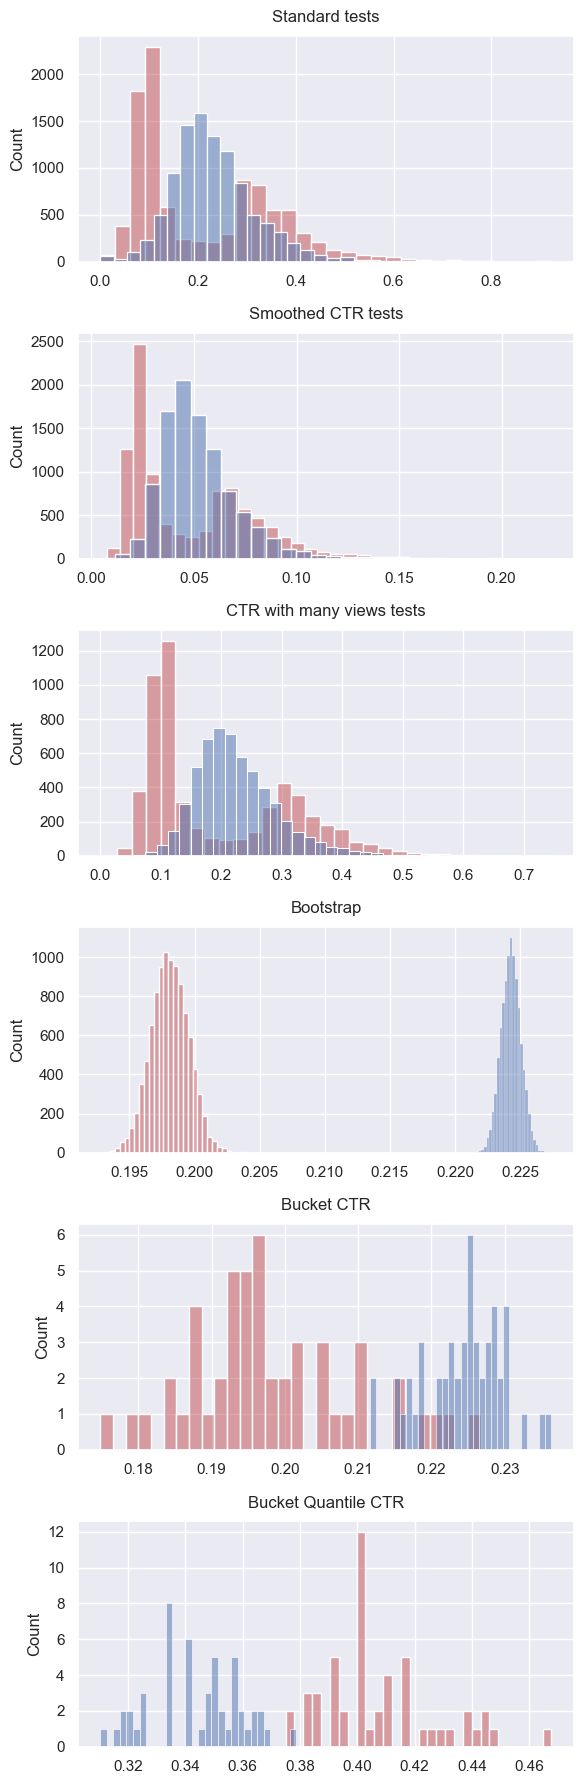

,T-test P value,Mann Whitneyu P value
Standard tests,3.303996e-27,1.403385e-106
Smoothed CTR tests,1.320679e-33,1.083360e-130
CTR with many views tests,2.324678e-49,2.834391e-124
Bootstrap,0.000000e+00,0.000000e+00
Bucket CTR,4.089170e-23,5.037909e-16
Bucket Quantile CTR,9.428416e-31,7.329733e-18


In [4]:
run_ab_test_ctr(data=experiment_data, 
                first_group=2,
                second_group=3, 
                bucket_data=bucket_exp_data)

## 3.3 Check additional method (linearized CTR metric)

In [5]:
from linearized_method import test_compare
sns.set(rc={'figure.figsize':(6, 4)})


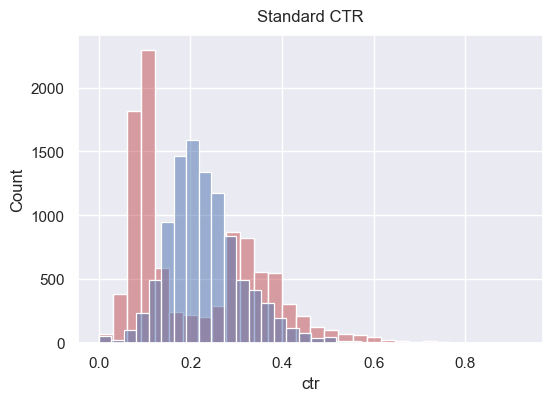

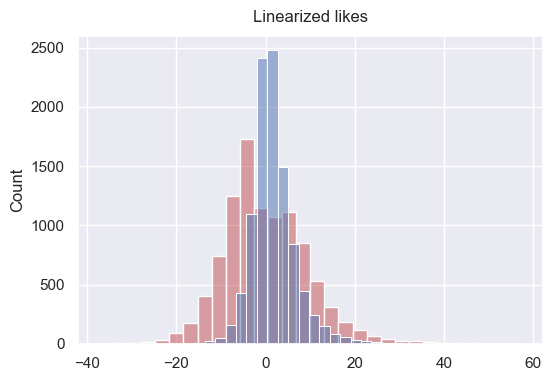

,Simple T-test,Linearized T-test
Comparing,3.303996e-27,1.709413e-59


In [6]:
test_compare(experiment_data, 2, 3)